# A simple language detector

## Objective:

The goal here is to create a language detector model based on "The Europarl parallel" corpus using classical techniques of Natural Language Processing and Machine Learning.<br/>
I will then use this model to detect the language of new sentences taken from Wikipedia.<br/>
This language detection task falls basically into Text Classification.

![png](img/language_detection_word_Art.jpg)

---

## Table of contents

1. [Data](#data)
2. [Data analysis](#data_analysis)
3. [Data pre-processing](#preprocessing)
4. [Preparing Datasets](#preparing_datasets)
5. [Variables definition](#variables)
6. [Data vectorization](#data_vectorization)
7. [Model](#model)
8. [Model evaluation](#evaluation)
9. [Inference](#inference)
10. [Conclusion](#conclusion)

### Importing libraries

In [1]:
import os
import time
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import dataframe_image as dfi
import pickle

### Global data path

In [2]:
data_path = "data/Europarl/"
corpus_path = data_path + "/Europarl_parallel_corpus"

## 1.Data<a id="data"></a>

The Europarl parallel corpus is extracted from the proceedings of the European Parliament. It includes versions in 21 European languages: Romanic (French, Italian, Spanish, Portuguese, Romanian), Germanic (English, Dutch, German, Danish, Swedish), Slavik (Bulgarian, Czech, Polish, Slovak, Slovene), Finni-Ugric (Finnish, Hungarian, Estonian), Baltic (Latvian, Lithuanian), and Greek.<br/>

For a detailed description of this corpus, please read Europarl: A Parallel Corpus for Statistical Machine Translation, Philipp Koehn, MT Summit 2005, <a href="https://homepages.inf.ed.ac.uk/pkoehn/publications/europarl-mtsummit05.pdf">Pdf</a>.<br/>

Get the original data <a href="http://www.statmt.org/europarl/">here</a>.

**I will use this corpus for language detection although it is originally intended for translation.**

Here under is a small table to visualize some basic informations about the data:

In [3]:
sentence_aligned_corpora_df = pd.read_csv(data_path + "Europarl_parallel_corpus_description.csv")
dfi.export(sentence_aligned_corpora_df, "img/language_detection_Europarl_parallel_corpus_description_df.png")

![png](img/language_detection_Europarl_parallel_corpus_description_df.png)

Each folder of the parallel corpus contains two files (exemple for bulgarian folder "bg-en"):
- text in the considered language: "europarl-v7.bg-en.bg"
- same text translated in english: "europarl-v7.bg-en.en"

**For language detection, I would keep only the texts in the languages considered. As to the detection of the English language, I will use the translation from French text file.**

## 2.Data analysis<a id="data_analysis"></a>

### Let's load the Czech data from folder

In [3]:
# Setting column width display option
pd.set_option('display.max_colwidth', 150)

In [4]:
czech_df = pd.read_csv(
    corpus_path + "/cs-en/europarl-v7.cs-en.cs",
    "UTF-8", names=["Czech Sentences"],
    engine='python')

dfi.export(czech_df.head(20), "img/language_detection_czech_df.png")

![png](img/language_detection_czech_df.png)

We can see in the first lines of this czech dataset that some greek words appears (row 11), as well as some italian words (row 9).<br/>
It is reasonable to think that there must exist many other imprecisions inside the dataframe.

We can also observe some sentences that contains just numbers. These will be treated during the pre-processing phase.

### Czech Data Exploration

Getting counts of sentences, words and characters:

In [5]:
total_num_words = 0
line_num_words = 0
num_char = 0
words_by_line = []
charDict = {}

for i, row in tqdm(czech_df.iterrows(), total=czech_df.shape[0]):
    line = row['Czech Sentences']
    line_num_words = len(line.split(" "))
    
    # words count
    total_num_words += line_num_words   
    words_by_line.append(line_num_words)
    
    # characters count
    for char in line:
        num_char += 1
        if char in charDict.keys():
            charDict[char] += 1
        else:
            charDict[char] = 1

100%|██████████| 646526/646526 [01:55<00:00, 5613.49it/s]


In [6]:
print("Number of sentences:", czech_df.shape[0])
print("Number of words:", total_num_words)
print("Minimum number of words by sentence:", min(words_by_line))
print("Maximum number of words by sentence:", max(words_by_line))

Number of sentences: 646526
Number of words: 12999948
Minimum number of words by sentence: 1
Maximum number of words by sentence: 227


In [7]:
print("Total number of characters:", num_char)
print(f'Number of different characters: {len(charDict)}')

Total number of characters: 87212619
Number of different characters: 269


### Let's check these characters and their occurrence in the detail

In [ ]:
charDict = dict(sorted(charDict.items(),key= lambda x:x[1], reverse=True))
print(charDict)

![png](img/Czech_charDict.png)

### And visualize the ordered occurrence of these characters

In [8]:
#setting plots background color
plt.rcParams.update({'axes.facecolor':'#f8fafc'})

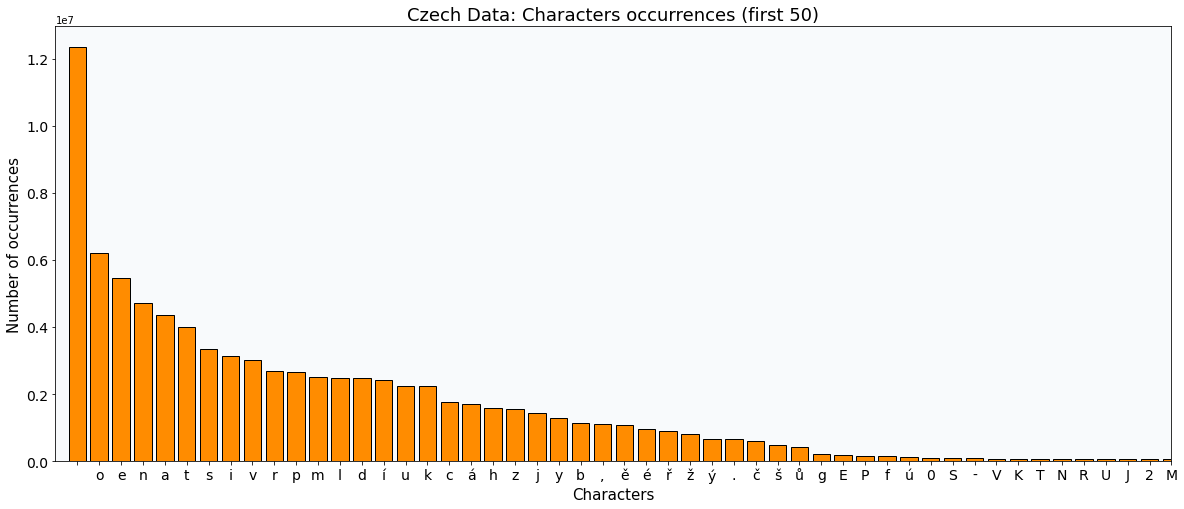

In [11]:
plt.figure(figsize=(20, 8))
plt.bar(range(len(charDict)), list(charDict.values()), align='center', edgecolor='black', color='darkorange')
plt.xticks(range(len(charDict)), list(charDict.keys()))
plt.tick_params(labelsize = 14)
plt.xlabel('Characters', fontsize = 15)
plt.ylabel('Number of occurrences', fontsize = 15)
plt.title('Czech Data: Characters occurrences (first 50)', fontsize = 18)
plt.xlim([-1, 50])
plt.show()

One can observe the occurrence of some typical Czech characters like ž ě ř č š ů.<br/>
Digits and Punctuation should be removed, as well as special characters. Capital letters will be lowered.

### Now let's see  how words and sentences are distributed

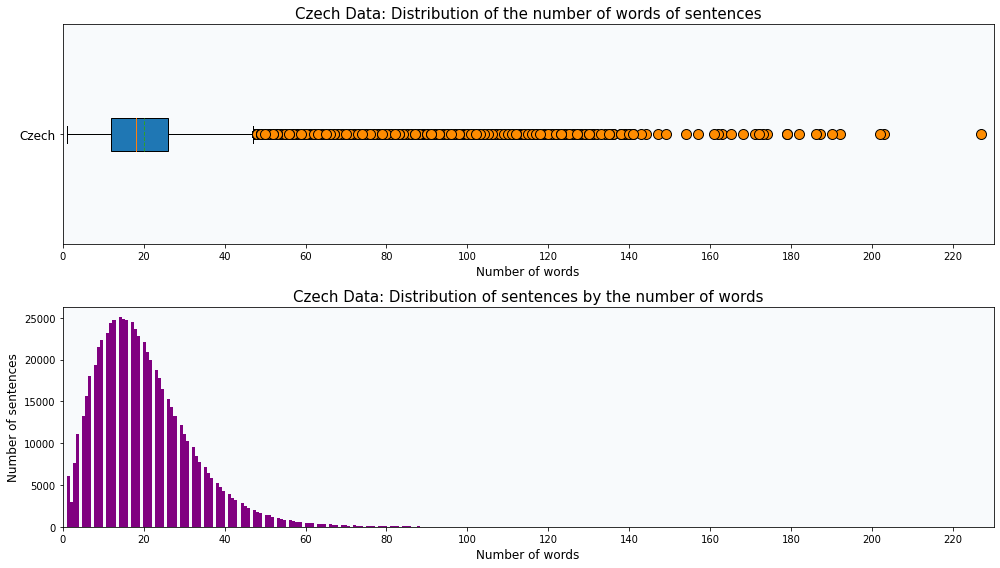

In [26]:
plt.figure(figsize=(14, 8))

# BOXPLOT
plt.subplot(211)
flierprops = dict(marker='o', markerfacecolor='darkorange', markersize=10)
plt.boxplot(words_by_line, vert=False, patch_artist=True, meanline=True, showmeans=True, flierprops=flierprops)
plt.xlabel('Number of words', fontsize = 12)
plt.title('Czech Data: Distribution of the number of words of sentences', fontsize = 15)
plt.xticks(np.arange(0, 230, 20))
plt.xlim([0,230])
plt.yticks([1,], ["Czech"], fontsize = 12)

# HISTOGRAM
plt.subplot(212)
plt.hist(words_by_line, bins=300, color='purple')
plt.xlabel('Number of words', fontsize = 12)
plt.ylabel('Number of sentences', fontsize = 12)
plt.title('Czech Data: Distribution of sentences by the number of words', fontsize = 15)
plt.xticks(np.arange(0, 230, 20))
plt.xlim([0,230])

plt.tight_layout()
plt.show()

We can observe many outliers: sentences with a higher amount of words.<br/>
On the other hand, we see that half of the sentences have less than 20 words.

## 3.Data pre-processing<a id="preprocessing"></a>

### Pre-processing steps:
- remove string begin/end spaces
- lower capital letters
- divide compound words (vice-president -> vice president)
- remove punctuation marks
- remove digits
- remove non-ascii characters
- remove extra spaces

### Let's see the result of each pre-processing steps on a simple exemple

In [43]:
text = """  PRE-Pross ! "# & '()*./:;+ ,- =>$? @ [\]^_ `{|} ~) ěï ū Щ %Ъ < ЫЭ §± »€ ≤• 223787° ý ł  """

In [44]:
# Defining dictionary for punctuation removal
for char in string.punctuation:
    print(char, end = ' ')
punctuation_marks = dict((ord(char), "") for char in string.punctuation)

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ 

In [45]:
print(text, "\n")
text = text.strip()                       # remove string begin/end spaces
print(text, "\n")
text = text.lower()                       # lower capital letters
print(text, "\n")
text = text.replace("-", " ")             # divide compound words
print(text, "\n")
text = text.translate(punctuation_marks)  # remove punctuation marks
print(text, "\n")
text = re.sub('\d+', '', text)            # remove digits
print(text, "\n")
text = re.sub('\\W',' ',text)             # remove non-ascii characters
print(text, "\n")
text = re.sub(' +', ' ', text)            # remove extra spaces
print(text, "\n")

  PRE-Pross ! "# & '()*./:;+ ,- =>$? @ [\]^_ `{|} ~) ěï ū Щ %Ъ < ЫЭ §± »€ ≤• 223787° ý ł   

PRE-Pross ! "# & '()*./:;+ ,- =>$? @ [\]^_ `{|} ~) ěï ū Щ %Ъ < ЫЭ §± »€ ≤• 223787° ý ł 

pre-pross ! "# & '()*./:;+ ,- =>$? @ [\]^_ `{|} ~) ěï ū щ %ъ < ыэ §± »€ ≤• 223787° ý ł 

pre pross ! "# & '()*./:;+ ,  =>$? @ [\]^_ `{|} ~) ěï ū щ %ъ < ыэ §± »€ ≤• 223787° ý ł 

pre pross            ěï ū щ ъ  ыэ §± »€ ≤• 223787° ý ł 

pre pross            ěï ū щ ъ  ыэ §± »€ ≤• ° ý ł 

pre pross            ěï ū щ ъ  ыэ            ý ł 

pre pross ěï ū щ ъ ыэ ý ł 



### Additional pre-processing step:

**I decided to rearrange the sentences during the data pre-processing phase so that I had the same specified number of words in each.**<br/>
**In this way, the machine learning model will be trained on a dataset with standardized length sentences.**

**I arbitrary choosed to set the length of sentences to 50 words**

- set lengh of sentences to 50 words:
    - each line wich has less than 50 words will be concatenated to the next one
    - each line wich has 50 or more words will be sliced in order to respect the given lenght of 50 words by sentences

By the way, this pre-processing can split or concatenate some valid sentences with sentences from other languages and could reduce the imprecision over text data.

In [16]:
def dataPreprocessing(dataframe, NB_WORDS_BY_ROW=50):
    """Processing data and dataframe"""
    """Each row of the dataframe will contain 'NB_WORDS_BY_ROW' words (50 by default)"""
    
    stack_line = ""
    nonAscii = re.compile('\\W') # need to compile regular expression for better performance

    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        line = row[dataframe.columns[0]]          # get text data (type str) from dataframe
        line = (stack_line + " " + line).strip()  # remove string begin/end spaces
        line = line.lower()                       # lower capital letters
        line = line.replace("-", " ")             # divide compound words (vice-president)
        line = line.translate(punctuation_marks)  # remove punctuation marks
        line = re.sub('\d+', '', line)            # remove digits       
        line = nonAscii.sub(' ', line)            # remove non-ascii characters
        line = re.sub(' +', ' ', line)            # remove extra spaces

        line_list = line.split()
        line_num_words = len(line_list)
        
        if line_num_words < NB_WORDS_BY_ROW:
            stack_line = line        # stack words of current line
            dataframe.iloc[i] = ""   # clear dataframe row

        elif line_num_words >= NB_WORDS_BY_ROW: # when NB_WORDS_BY_ROW criteria is reached
            # write down in dataframe the sentence with the specified number of words
            dataframe.iloc[i] = ' '.join(line_list[0:NB_WORDS_BY_ROW])
            # and stack the lasts words
            stack_line = ' '.join(line_list[NB_WORDS_BY_ROW:])

    # remove empty rows and shuffle rows of dataframe
    drop_indexes = dataframe[dataframe[dataframe.columns[0]] == ""].index
    dataframe.drop(drop_indexes, inplace=True)
    dataframe = dataframe.sample(frac=1)
    dataframe.reset_index(drop=True, inplace=True)
    
    return dataframe

### As a verification, let's apply pre-processing on English language data

In [17]:
english_df = pd.read_csv(
    corpus_path + "/en-en/europarl-v7.fr-en.en",
    "UTF-8", names=["English Sentences"],
    engine='python')

In [18]:
english_df_preproc = dataPreprocessing(english_df)
dfi.export(english_df_preproc.head(10), "img/language_detection_english_df_preproc.png")

100%|██████████| 2005688/2005688 [10:22<00:00, 3220.82it/s]


![png](img/language_detection_english_df_preproc.png)

### Now let's check the characters that make up the words and sentences of English data after pre-processing

In [19]:
charDict = {}

for i, row in tqdm(english_df_preproc.iterrows(), total=english_df_preproc.shape[0]):
    line = row['English Sentences']
    for char in line:
        if char in charDict.keys():
            charDict[char] += 1
        else:
            charDict[char] = 1

100%|██████████| 999912/999912 [03:12<00:00, 5194.18it/s]


In [20]:
print(f'Number of different characters: {len(charDict)}')

Number of different characters: 167


### Check these characters and their occurrence in detail

In [ ]:
charDict = dict(sorted(charDict.items(),key= lambda x:x[1], reverse=True))
print(charDict)

![png](img/English_charDict.png)

After pre-processing, we can observe the occurrence of some characters that belongs to other languages (ß έ й ε ã ...), and other special characters (¼ º ½ ¾) that has not been removed during pre-processing. It confirms what we saw during the data analysis: depending on the results and performance of the language detection model, we could have to clean the data a little more precisely.

### And visualize the ordered occurrence of these characters

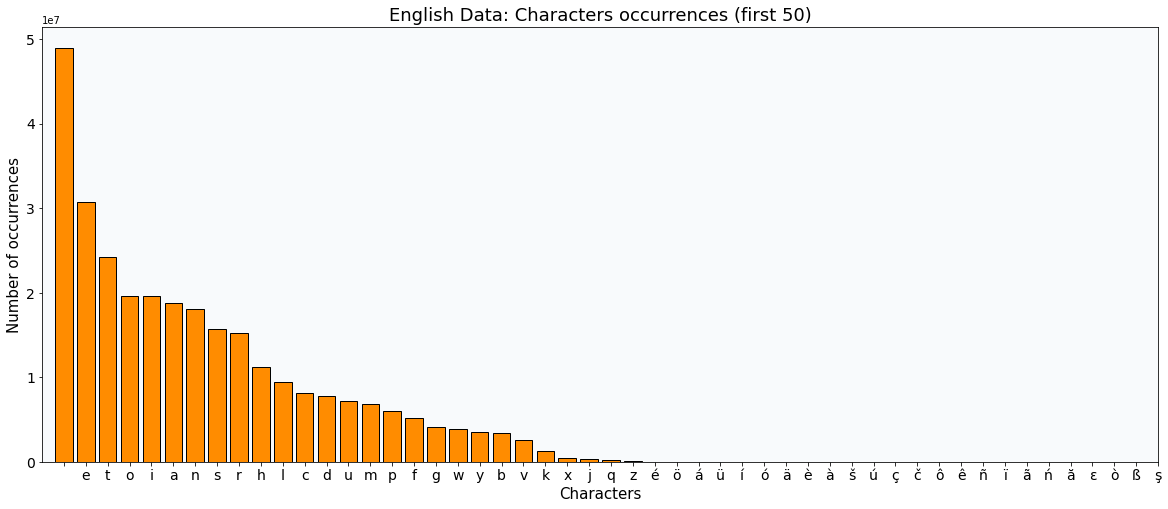

In [22]:
plt.figure(figsize=(20, 8))
plt.bar(range(len(charDict)), list(charDict.values()), align='center', edgecolor='black', color='darkorange')
plt.xticks(range(len(charDict)), list(charDict.keys()))
plt.tick_params(labelsize = 14)
plt.xlabel('Characters', fontsize = 15)
plt.ylabel('Number of occurrences', fontsize = 15)
plt.title('English Data: Characters occurrences (first 50)', fontsize = 18)
plt.xlim([-1, 50])
plt.show()

However, we observe here that the characters having a significant occurrence are those which compose classic English words and sentences! The appearance of characters that belongs to other languages and remaining special characters seems to be anecdotal.

**So let's keep it like this for the moment, and do some more precise data cleaning later if necessary.**

### Corpus pre-processing

**Now let's pre-process sentences for all languages of the entire corpus**

Note: for english data, I choosed the file from <a href="http://www.statmt.org/europarl/v7/fr-en.tgz">"fr-en"</a> folder which is the english translated text from the french text.

In [23]:
langDict = {
    'bg': 'Bulgarian',
    'cs': 'Czech',
    'da': 'Danish',
    'de': 'German',
    'el': 'Greek',
    'en': 'English',
    'es': 'Spanish',
    'et': 'Estonian',
    'fi': 'Finnish',
    'fr': 'French',
    'hu': 'Hungarian',
    'it': 'Italian',
    'lt': 'Lithuanian',
    'lv': 'Latvian',
    'nl': 'Dutch',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'sk': 'Slovak',
    'sl': 'Slovenian',
    'sv': 'Swedish'
}

**For calculation purpose and to prevent memory issues that occurs with this large corpus, for each language, only 100000 sentences will be randomly selected.**

In [24]:
languages = []
d = {}
    
for _, (key, language) in enumerate(langDict.items()):
    print(language)
    languages.append(language)
    folder = key + '-en'  # a folder name is like "bg-en"
    files_path = os.path.join(corpus_path, folder)

    for file in os.listdir(files_path):
        d[language] = pd.read_csv(files_path + "/" + file, "UTF-8", names=["Sentences"], engine='python')
        d[language] = d[language].sample(frac=1)          # randomize sentences
        d[language].reset_index(drop=True, inplace=True)
        d[language] = d[language].iloc[0:100000].copy()   # select 100000 sentences
        d[language] = dataPreprocessing(d[language])      # pre-processing sentences
        d[language]['Language'] = language                # add column that indicates the language

Bulgarian


100%|██████████| 100000/100000 [00:32<00:00, 3045.56it/s]


Czech


100%|██████████| 100000/100000 [00:32<00:00, 3052.08it/s]


Danish


100%|██████████| 100000/100000 [00:32<00:00, 3084.68it/s]


German


100%|██████████| 100000/100000 [00:33<00:00, 2997.50it/s]


Greek


100%|██████████| 100000/100000 [00:34<00:00, 2910.47it/s]


English


100%|██████████| 100000/100000 [00:29<00:00, 3345.92it/s]


Spanish


100%|██████████| 100000/100000 [00:33<00:00, 2998.63it/s]


Estonian


100%|██████████| 100000/100000 [00:32<00:00, 3090.61it/s]


Finnish


100%|██████████| 100000/100000 [00:33<00:00, 3012.31it/s]


French


100%|██████████| 100000/100000 [00:33<00:00, 2970.94it/s]


Hungarian


100%|██████████| 100000/100000 [00:33<00:00, 2963.75it/s]


Italian


100%|██████████| 100000/100000 [00:33<00:00, 3007.12it/s]


Lithuanian


100%|██████████| 100000/100000 [00:32<00:00, 3056.49it/s]


Latvian


100%|██████████| 100000/100000 [00:32<00:00, 3062.43it/s]


Dutch


100%|██████████| 100000/100000 [00:31<00:00, 3220.98it/s]


Polish


100%|██████████| 100000/100000 [00:33<00:00, 2983.80it/s]


Portuguese


100%|██████████| 100000/100000 [00:33<00:00, 3013.53it/s]


Romanian


100%|██████████| 100000/100000 [00:33<00:00, 2992.63it/s]


Slovak


100%|██████████| 100000/100000 [00:32<00:00, 3050.19it/s]


Slovenian


100%|██████████| 100000/100000 [00:32<00:00, 3109.38it/s]


Swedish


100%|██████████| 100000/100000 [00:32<00:00, 3056.71it/s]


## 4.Preparing Datasets<a id="preparing_datasets"></a>

### Now we are ready to create our Train and Test sets by concatenating dataframes of each language:<br/>
- 80% of the data dedicated to Train set
- 20% of the data dedicated to Test set

In [25]:
train_df = pd.DataFrame()
test_df  = pd.DataFrame()

In [26]:
for language in languages:
    ratio = int(d[language].shape[0] * 0.8)
    train_df = pd.concat([train_df, d[language][0:ratio]], axis=0)
    test_df  = pd.concat([test_df,  d[language][ratio:]],  axis=0)

# Saving Train and Test datasets as csv files
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.to_csv(data_path + '/Europarl_csv/train_df.csv', index = False)
test_df.to_csv(data_path + '/Europarl_csv/test_df.csv', index = False)

In [27]:
print(train_df.shape)
print(test_df.shape)

(741158, 2)
(185303, 2)


In [28]:
dfi.export(train_df.tail(), "img/language_detection_train_df.png")

![png](img/language_detection_train_df.png)

In [29]:
dfi.export(test_df.tail(), "img/language_detection_test_df.png")

![png](img/language_detection_test_df.png)

### Visualizing the  number of sentences for each language

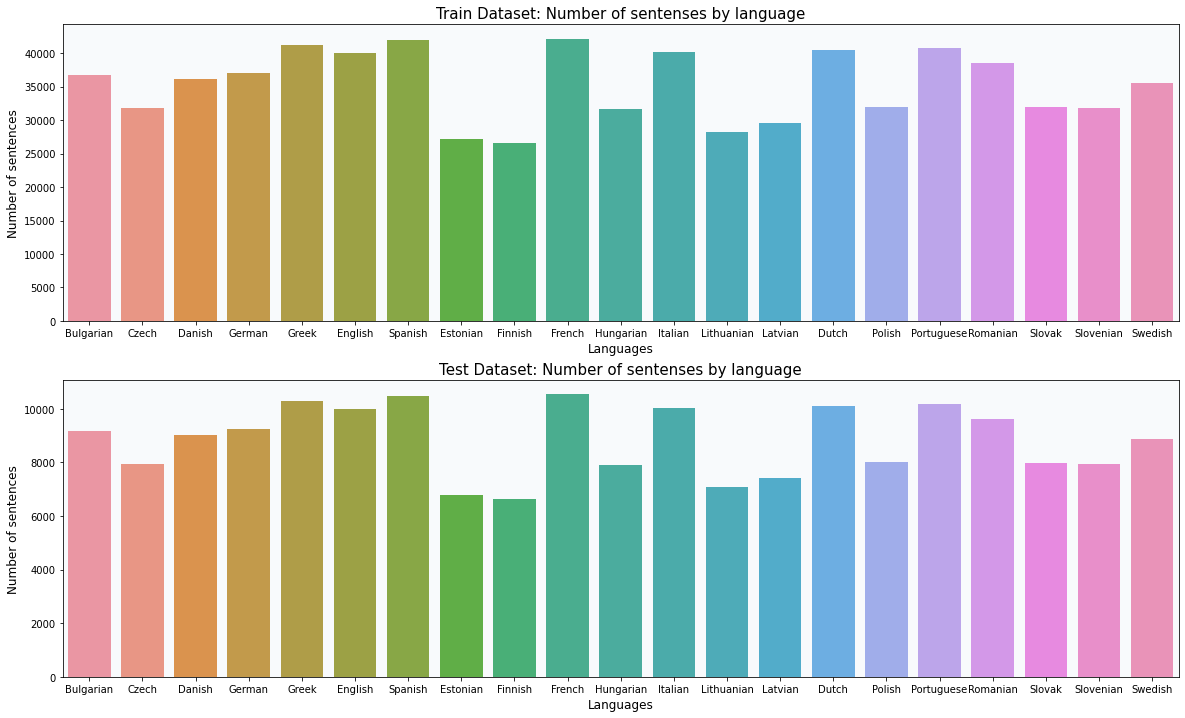

In [50]:
plt.figure(figsize=(20, 12))

# TRAIN DATASET
plt.subplot(211)
sns.countplot(data=train_df, x=train_df['Language'])
plt.xlabel('Languages', fontsize = 12)
plt.ylabel('Number of sentences', fontsize = 12)
plt.title('Train Dataset: Number of sentenses by language', fontsize = 15)

# TEST DATASET
plt.subplot(212)
sns.countplot(data=test_df, x=test_df['Language'])
plt.xlabel('Languages', fontsize = 12)
plt.ylabel('Number of sentences', fontsize = 12)
plt.title('Test Dataset: Number of sentenses by language', fontsize = 15)

plt.show()

Since the sentences of all languages are initially variable length, the result of the preprocessing gives us a different number of normalized length sentences for each language.

## 5.Variables definition<a id="variables"></a>

### Creating variables for model input

In [31]:
train_df = pd.read_csv(data_path + '/Europarl_csv/train_df.csv', index_col = False)

X_train = train_df.iloc[:,0] # Independent Variable
y_train = train_df.iloc[:,1] # Dependent Variable

In [32]:
test_df  = pd.read_csv(data_path + '/Europarl_csv/test_df.csv', index_col = False)

X_test = test_df.iloc[:,0] # Independent Variable
y_test = test_df.iloc[:,1] # Dependent Variable

## 6.Data vectorization<a id="data_vectorization"></a>

### Applying TF-IDF Vectorizer with Character Tokenization

I chose Character Tokenization because characters are the most relevant entities to recognize a language.<br/>

One can found on Wikipedia a <a href="https://en.wikipedia.org/wiki/Wikipedia:Language_recognition_chart">Language recognition chart</a>: "This language recognition chart presents a variety of clues one can use to help determine the language in which a text is written."<br/>

Here under an extract of the article:

![png](img/language_detection_chart1.png)

[...]

![png](img/language_detection_chart2.png)

Furhtermore, Character Tokenization splits a sentence into a set of characters, so it can overcomes **"Out Of Vocabulary"** words coherently by preserving the information of the word, and limits the size of the vocabulary.

I use the **TfidfVectorizer** from Scikit-Learn library to convert raw sentences into matrix of TF-IDF features.
Selecting the **'char_wb' option** to create n-grams of characters only from text inside word boundaries; n-grams at the edges of words are padded with space (whitespace can begin or end trigrams but cannot be in the middle).

In [33]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3), analyzer='char_wb')

### Let's test this vectorizer on the Italian data:

In [34]:
Italian_Sentences = d["Italian"].iloc[:,0]
print(Italian_Sentences.shape)

(50207,)


In [35]:
print(Italian_Sentences[0])

è tuttora caratterizzata da una mancanza di parità tra i generi vorrei ringraziarvi per linteresse dimostrato verso lordine del giorno del prossimo consiglio europeo e sarò lieto di raccogliere i vostri stimolanti commenti e pareri in occasione della prossima discussione ho votato a favore della relazione gröner sulla lotta contro


In [36]:
Italian_vect = vectorizer.fit_transform(Italian_Sentences)
Italian_vect = pd.DataFrame(Italian_vect.toarray(), columns= vectorizer.get_feature_names())

In [37]:
Italian_vect.shape

(50207, 9398)

As we see the number of features (for Italian data) is equal to 9398.

In [38]:
dfi.export(Italian_vect.head(10), "img/language_detection_italian_vect.png", max_cols=20)

![png](img/language_detection_italian_vect.png)

And as expected, we can find some features that are composed with characters from other languages.

## 7.Model<a id="model"></a>

### Model definition

For classification, I selected in a first approach the logistic regression model from Scikit-Learn library.<br/>
The Vectorizer and the Classifier are then combined in a pipeline:

In [39]:
Language_detector = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', LogisticRegression(max_iter=1000))
])

### Model training

In [40]:
start_time = time.time()
Language_detector.fit(X_train, y_train)
end_time = time.time()
print("\nProcessing time = {:0.2f} min".format((end_time - start_time)/60))


Processing time = 43.20 min


## 8.Model evaluation<a id="evaluation"></a>

### Accuracy

In [41]:
y_test_pred = Language_detector.predict(X_test)

In [42]:
accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Test Accuracy = {accuracy:.2f}%")

Test Accuracy = 100.00%


Awesome! Even with special characters and characters from other languages, a 100% accuracy is achieved on test data.

### Classification report

In [43]:
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

   Bulgarian       1.00      1.00      1.00      9180
       Czech       1.00      1.00      1.00      7948
      Danish       1.00      1.00      1.00      9034
       Dutch       1.00      1.00      1.00     10101
     English       1.00      1.00      1.00      9990
    Estonian       1.00      1.00      1.00      6804
     Finnish       1.00      1.00      1.00      6649
      French       1.00      1.00      1.00     10541
      German       1.00      1.00      1.00      9259
       Greek       1.00      1.00      1.00     10290
   Hungarian       1.00      1.00      1.00      7905
     Italian       1.00      1.00      1.00     10042
     Latvian       1.00      1.00      1.00      7404
  Lithuanian       1.00      1.00      1.00      7073
      Polish       1.00      1.00      1.00      8005
  Portuguese       1.00      1.00      1.00     10184
    Romanian       1.00      1.00      1.00      9623
      Slovak       1.00    

Precision, recall and f1-score all reach the maximum value !

### Confusion matrix

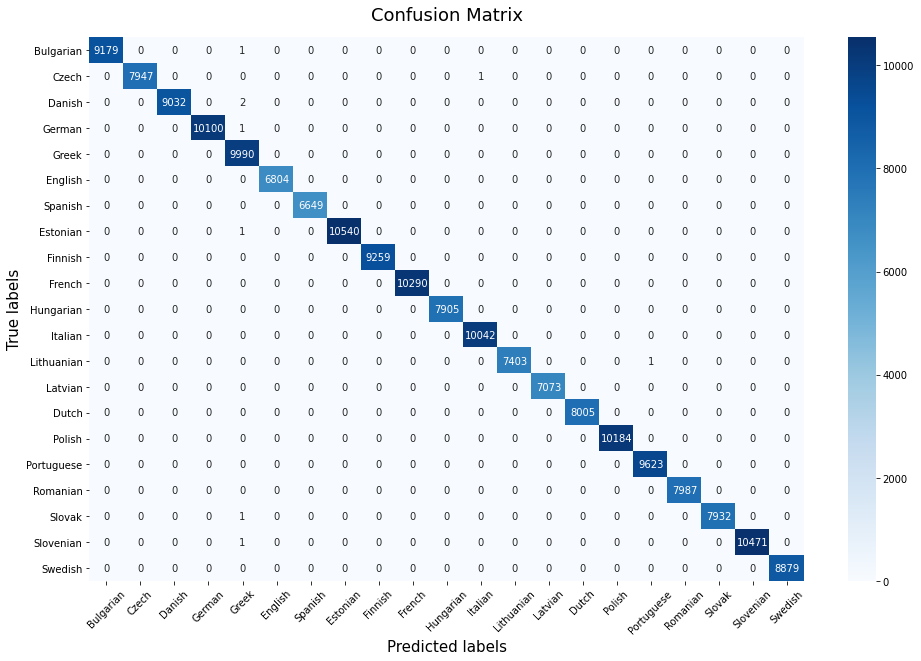

In [44]:
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', xticklabels=languages, yticklabels=languages)
plt.ylabel('True labels', size=15)
plt.xlabel('Predicted labels', size=15)
plt.xticks(rotation=45)
plt.title('Confusion Matrix', size=18, y=1.02)
plt.show()

The model has near perfect language classification and detection capability on test data!<br/>
And it is reasonable to think that the misclassifications observed here are the result of the remaining sentences from other languages.

### Saving model

In [45]:
pickle.dump(Language_detector, open(data_path + "Language_detector.model", "wb"))

Gives us the possibility to re-use this pre-trained model for deployment (in web application for exemple).

## 9.Inference<a id="inference"></a>

### Importing the model

In [27]:
Language_detector = pickle.load(open(data_path + "Language_detector.model", "rb"))

### Inference on new sentences

Let's pick up few sentences in different languages from Wikipedia and test our model's language detection capability:

In [28]:
inference_sentences = {
    'Bulgarian':  "Статистиката е дисциплина, която се занимава със събирането, организирането, анализа, интерпретацията и представянето на данни.",
    'Czech':      "Statistika je vědní obor, který se zabývá sběrem, organizací, analýzou, interpretací a prezentací empirických dat za účelem prohloubení znalostí určité oblasti, obvykle hromadného jevu.",
    'Danish':     "Statistik er en videnskabelig metode, hvormed man effektivt anvender numeriske data, som fx kan komme fra eksperimenter, spørgeskemaer eller registre.",
    'German':     "Statistik „ist die Lehre von Methoden zum Umgang mit quantitativen Informationen“ (Daten).[1] Sie ist eine Möglichkeit, „eine systematische Verbindung zwischen Erfahrung (Empirie) und Theorie herzustellen“.",
    'Greek':      "Η Στατιστική είναι μία μεθοδική μαθηματική, παλαιότερα τεχνική και σήμερα επιστήμη που επιχειρεί να εξαγάγει έγκυρη γνώση χρησιμοποιώντας εμπειρικά δεδομένα παρατήρησης ή και πειράματος.",
    'English':    "Statistics is the discipline that concerns the collection, organization, analysis, interpretation, and presentation of data.",
    'Spanish':    "La estadística (la forma femenina del término alemán Statistik, derivado a su vez del italiano statista, hombre de Estado),1​ es la rama de las matemáticas que estudia la variabilidad, colección, organización, análisis, interpretación, y presentación de los datos, así como el proceso aleatorio que los genera siguiendo las leyes de la probabilidad.",
    'Estonian':   "Statistika ehk arvustikuteadus on teadus, mis käsitleb andmete kogumist, töötlemist ja analüüsi. Statistika on teadus massnähtuste kvantitatiivse uurimise meetoditest.",
    'Finnish':    "Tilastotiede on todennäköisyyslaskentaan perustuva tieteenala, joka tutkii tilastollisten aineistojen keräämistä, käsittelyä ja tältä pohjalta tehtävää päättelyä.",
    'French':     "La statistique est la discipline qui étudie des phénomènes à travers la collecte de données, leur traitement, leur analyse, l'interprétation des résultats et leur présentation afin de rendre ces données compréhensibles par tous.",
    'Hungarian':  "A statisztika avagy számhasonlítás[1] a valóság számszerű információinak megfigyelésére, összegzésére, elemzésére és modellezésére irányuló gyakorlati tevékenység és tudomány. ",
    'Italian':    "La statistica è una disciplina che ha come fine lo studio quantitativo e qualitativo di un particolare fenomeno collettivo in condizioni di incertezza o non determinismo, cioè di non completa conoscenza di esso o di una sua parte.",
    'Lithuanian': "Statistika – tikslusis mokslas, kuriame efektyviai panaudojami duomenys iš gautų bandymų ir eksperimentų. Į tai įeina ne tik duomenų rinkimas, jų analizė ir interpretavimas, tačiau ir duomenų prognozavimas iš apklausų ir eksperimentų rezultatų.",
    'Latvian':    "Statistika ir zinātne, kas nodarbojas ar datu iegūšanu, apstrādi, analīzi un to izskaidrošanu.[1] Statistika tiek plaši izmantota dažādās jomās, piemēram, valsts iestādēm statistiskie dati, kurus tās iegūst no tautas skaitīšanas, ir nepieciešami, lai noskaidrotu sabiedrības dzīves un tautsaimniecības kvantitatīvās likumsakarības.",
    'Dutch':      "Statistiek is de wetenschap en de techniek van het verzamelen, bewerken, interpreteren en presenteren van gegevens.",
    'Polish':     "Statystyka (niem. Statistik, „badanie faktów i osób publicznych”, z łac. [now.] statisticus, „polityczny, dot. polityki”, od status, „państwo, stan”) – nauka, której przedmiotem zainteresowania są metody pozyskiwania i prezentacji, a przede wszystkim analizy danych opisujących zjawiska, w tym masowe. ",
    'Portuguese': "Estatística é a ciência que utiliza as teorias probabilísticas para explicar a frequência da ocorrência de eventos,[1] tanto em estudos observacionais quanto em experimentos para modelar a aleatoriedade e a incerteza de forma a estimar ou possibilitar a previsão de fenômenos futuros, conforme o caso. ",
    'Romanian':   "Statistica este o știință care, folosind calculul probabilităților, studiază fenomenele și procesele de tip colectiv (din societate, natură etc.) din punct de vedere cantitativ[1][2] în scopul descrierii acestora și al descoperirii legilor care guvernează manifestarea lor.",
    'Slovak':     "Štatistika je veda založená na využívaní empirických (t. j. založených na skúsenostiach) dát.",
    'Slovenian':  "Statístika je znanost in veščina o razvoju znanja z uporabo izkustvenih podatkov. Njena osnova je matematična statistika, ki je veja uporabne matematike.",
    'Swedish':    "Statistik är en gren inom tillämpad matematik som sysslar med insamling, utvärdering, analys och presentation av data eller information.",
}

In [38]:
# Setting column width display option
pd.set_option('display.max_colwidth', 100)

In [39]:
data = []
for _, (language, sentence) in enumerate(inference_sentences.items()):
    sentence_array = np.array(sentence).reshape(-1)
    predicted_language = Language_detector.predict(sentence_array)
    data.append([sentence, language, predicted_language[0]])

inference_df = pd.DataFrame(data, columns=["Sentence", "Language", "Predicted language"])
dfi.export(inference_df, "img/language_detection_inference_df.png")

![png](img/language_detection_inference_df.png)

Thus I can build a language detection parser which takes a sentence as input and returns the detected language accordingly.

### Language detection parser

In [57]:
sentence = input('Sentence: \n')
sentence_array = np.array(sentence).reshape(-1)
predicted_language = Language_detector.predict(sentence_array)
print("\n")
print(f'Language detected: {predicted_language[0]}')

Sentence: 
Automatisch leren, machinaal leren of machine learning is een breed onderzoeksveld binnen kunstmatige intelligentie, dat zich bezighoudt met de ontwikkeling van algoritmes en technieken waarmee computers kunnen leren. 


Language detected: Dutch


## 10.Conclusion<a id="conclusion"></a>

The Europarl parallel corpus - extracted from the proceedings of the European Parliament - includes versions in 21 European languages.<br/>
I used this corpus originally intended for translation to build a language detection model.

The analysis of the data revealed some imprecisions: each language data contains some sentences from other languages, and these imprecisions exists for all language data:<br/>
- Analysing characters, the occurrence of letters of other alphabets allow us to understand that these appearances are anecdotal.
- On the other hand it is more difficult to estimate the number of sentences of other languages whose alphabets are common with the considered language.

Despite of this, I made the initial hypothesis that these sentences are rare enough to be unsignificant, and do some more precise data cleaning in a second step if necessary.

Then I applied the following basic pre-processing techniques:
- remove string begin/end spaces
- lower capital letters
- divide compound words
- remove punctuation marks
- remove digits
- remove non-ascii characters
- remove extra spaces
- set the length of sentences to 50 words

I arbitrary choosed to set the length of sentences to 50 words, in order to train a machine learning model on a dataset with standardized word length sentences. Sentences has been concatenated or sliced to fit this given word length.<br/>
This pre-processing is possible as for language detection I do not analyse the semantic content of sentences but only words or characters.<br/>
By the way, this pre-processing can split or concatenate some valid sentences with sentences from other languages and could reduce the imprecision over text data.

For calculation purpose and to prevent memory issues that occurs with this large corpus, I randomly selected only 100000 sentences for each language.

For the Natural Language Processing, I chose Character Tokenization because characters and n-grams of characters are the most relevant entities to recognize a language, it can overcomes "Out Of Vocabulary" words coherently by preserving the information of the word, as well as limiting the size of the vocabulary.

I built a Machine Learning model with a pipeline combining a Vectorizer and a Classifier:
- Vectorizer: the TfidfVectorizer from Scikit-Learn library which convert raw sentences into matrix of TF-IDF features, selecting the 'char_wb' option to create unigram, bigram and trigram features of characters only from text inside word boundaries.
- Classifier: the logistic regression model from Scikit-Learn library.

The model's training converged in 43 min with enough but borderline memory load!

The model evaluation shows:
- 100% accuracy on test data, ven with special characters and characters from other languages.
- Precision, recall and f1-score all reach the maximum value.
- The model shows a near perfect language classification and detection capability on test data.

**Now we have a language detection model that can predict accurately the language (in the list the Europarl corpus languages) of any new sentence, and that can be deployed on a web application for exemple.**